## Generative Adverserial Network

In [ ]:
from IPython.display import Image
%matplotlib inline

### Improving the quality of synthesized images using DCGAN

---

#### **Recap on to Vanilla GAN**
   - **Basic Structure**: In a Vanilla GAN, there are two primary components—a *Generator (G)* and a *Discriminator (D)*. The Generator attempts to create realistic-looking fake samples from random noise, while the Discriminator tries to distinguish real samples from the fake ones. Both components play a minimax game, constantly improving to “outsmart” each other.
   - **Objective**: The objective of the GAN is to reach a Nash equilibrium where the Generator can produce indistinguishable fake samples, and the Discriminator can no longer tell real from fake with high accuracy.

#### **Deep Convolutional GANs**

   - Deep Convolutional GANs (DCGANs) introduced convolutional layers to both the Generator and Discriminator, revolutionizing how GANs handle image generation. [Source: *Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*](https://arxiv.org/abs/1511.06434)

   - **How DCGAN Improves over Vanilla GAN**:
     - *Architecture Adjustments*: DCGAN replaces fully connected layers with convolutional and transposed convolutional layers, which help capture spatial hierarchies in images, improving output quality.
     - *Batch Normalization*: By adding batch normalization, DCGAN helps stabilize training and accelerates convergence. Batch normalization in both the Generator and Discriminator layers helps address training instabilities.
     - *Removing Pooling Layers*: Instead of pooling, DCGAN uses strided convolutions, giving the network more flexibility and reducing information loss, thus addressing mode collapse partially by better preserving details across image generations.

![Figure from https://arxiv.org/pdf/1511.06434](https://pytorch.org/tutorials/_images/dcgan_generator.png)


**But how can we go from 1D to a 2D picture?**


### What is Transposed convolution?

Transposed convolution, also known as deconvolution or fractionally strided convolution, is a technique used in deep learning to upsample feature maps, effectively increasing their spatial dimensions. This operation is particularly valuable in tasks such as image generation, semantic segmentation, and super-resolution, where reconstructing high-resolution outputs from lower-resolution inputs is essential.

#### Convolution and Its Inverse

In standard convolution operations, a kernel (filter) slides over an input feature map, producing an output feature map with reduced spatial dimensions, depending on parameters like stride and padding. Transposed convolution aims to reverse this process, expanding the spatial dimensions of the input feature map to produce a larger output.

#### Mechanism of Transposed Convolution

The transposed convolution process can be understood through the following steps:

#### a. Input Expansion

The input feature map is expanded by inserting zeros between its elements, effectively increasing its dimensions. The amount of expansion depends on the desired output size and the stride used in the original convolution.

#### b. Kernel Application

A convolutional kernel is then applied to this expanded input. Unlike standard convolution, where the kernel moves over the input, in transposed convolution, the kernel is applied to the expanded input to produce overlapping regions in the output.

#### c. Overlap Summation

The overlapping regions in the output are summed to produce the final upsampled feature map.

This process effectively increases the spatial dimensions of the input feature map, allowing the network to learn how to upsample features in a learnable manner.

#### Mathematical Formulation

The output dimensions of a transposed convolution can be calculated using the following formula:

$$
\text{o} = (\text{n} - 1) \times \text{s} - 2 \times \text{p} + \text{m} + \text{op}
$$

Where:

- **n**: Spatial dimensions of the input feature map.
- **s**: Step size with which the kernel is applied.
- **m**: Dimensions of the convolutional kernel.
- **p**: Number of pixels added to the input feature map borders.
- **op**: Ouput Padding. Additional pixels added to the output feature map dimensions.

This formula helps determine the spatial dimensions of the output feature map, ensuring it matches the desired size.

#### Implementation in Deep Learning Frameworks

Most deep learning frameworks provide built-in functions for transposed convolution:

- **PyTorch**: [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) applies a 2D transposed convolution operator over an input image composed of several input planes.
- **TensorFlow/Keras**: [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) is used to apply a 2D transposed convolution layer.

---

Here is demonstraion of deconvolution operation

![](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiGKShf5RPVMntFYtLQhNfI4wVb4l7-4wzfSbOW4YOIpsX2RyTFrPZgbaIFfZGdbMJmiPgNNI4SFLkoE2YC4PZFOfdWVgLL5N97K6JYDcKfBx4v3sLmO6zwRcbg2vcb2RCblNeLQmebC-Mm/s1600/appendix_C_eg_5.png)


Figure [Source: Make your own neural network](http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html)

### Batch normalization

This is as well essential for DCGAN implementation. We had discussed about Bactch norm in [Lecture 13](https://cfteach.github.io/NNDL_DATA621/lec13_Introduction_to_grad_cam_v2.html#batch-normalization)


![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/batch_norm.png?raw=true)

### Implementing the generator and discriminator


The generator for MNIST digit dataset will be

![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/generator.png?raw=true)


The discriminator for MNIST digit dataset will be

![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/discriminator.png?raw=true)

In [ ]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.5.0+cu121
GPU Available: True


In [ ]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Train the DCGAN model

In [ ]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 128

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)


In [ ]:
def make_generator_network(input_size, n_filters):
    #nn.ConvTranspose2d(in_channels = input_size,
    #                   out_channels = n_filters*4,
    #                   kernel_size = 4,
    #                   stride = 1,
    #                   padding = 0,
    #                   output_padding = 0,
    #                   bias = False
    #                   )
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)


In [ ]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)


In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [ ]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [ ]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()


In [ ]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z, batch_size):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

num_epochs = 50
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z, batch_size).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.3853/0.1600
Epoch 002 | Avg Losses >> G/D 3.6382/0.2976
Epoch 003 | Avg Losses >> G/D 3.4910/0.3260
Epoch 004 | Avg Losses >> G/D 3.4770/0.3314
Epoch 005 | Avg Losses >> G/D 3.5152/0.3350
Epoch 006 | Avg Losses >> G/D 3.5486/0.3222
Epoch 007 | Avg Losses >> G/D 3.5563/0.3272
Epoch 008 | Avg Losses >> G/D 3.6236/0.3157
Epoch 009 | Avg Losses >> G/D 3.5947/0.3217
Epoch 010 | Avg Losses >> G/D 3.6332/0.3226
Epoch 011 | Avg Losses >> G/D 3.6489/0.3174
Epoch 012 | Avg Losses >> G/D 3.6870/0.3155
Epoch 013 | Avg Losses >> G/D 3.7142/0.3097
Epoch 014 | Avg Losses >> G/D 3.8028/0.3117
Epoch 015 | Avg Losses >> G/D 3.7953/0.3159
Epoch 016 | Avg Losses >> G/D 3.7584/0.3093
Epoch 017 | Avg Losses >> G/D 3.8095/0.3089
Epoch 018 | Avg Losses >> G/D 3.8293/0.3101
Epoch 019 | Avg Losses >> G/D 3.8663/0.3118
Epoch 020 | Avg Losses >> G/D 3.8494/0.3051
Epoch 021 | Avg Losses >> G/D 3.8735/0.3056
Epoch 022 | Avg Losses >> G/D 3.8852/0.3004
Epoch 023 | Avg Losses >> G/D 3.

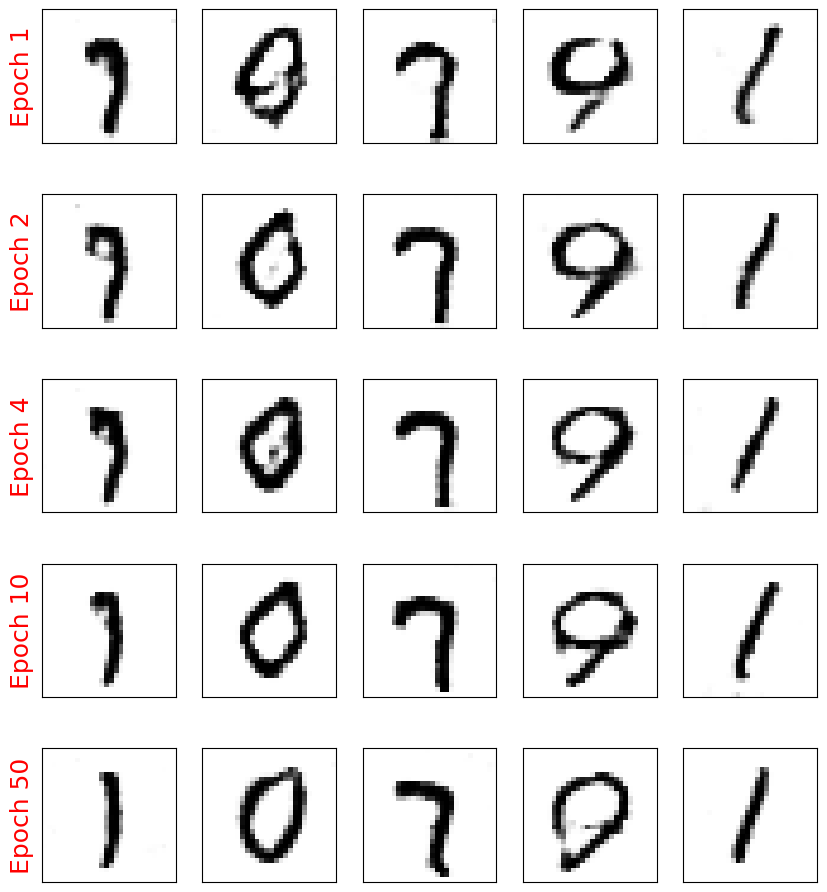

In [ ]:
selected_epochs = [1, 2, 4, 10, 50]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

#### Limitations of DCGAN

DCGAN still suffers from some mode collapse and instability in complex data settings. While it stabilizes the learning process, it doesn’t fundamentally address the underlying adversarial loss limitations. But certainly improves the quality of reconstruction due to its ability to capture spatial correaltion quickly than Vanilla GAN.

### How to assess the quality of Generation?

How can we measure the quality of our generations. More importantly, How can one determine if the model simply did not memorize the patterns and are reproducing them?


#### Dissimilarity measures between two distributions


Check out other metrics for dis-similarity from the reference book.
![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/Dis-similarity.png?raw=true)




An example is shown here

![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/Dis-similarity-discrete.png?raw=true)



#### Steps to extract TVD (One of the ways)

1. Generate a set of `N` images using the generator
2. Extract using a simple CNN a feature set for both generated images and real images
3. Perform a PCA to futher push down the dimensions to a single variable `X`. Caveat -- One can also simply use the CNN To output a single valued function (eg: `tanh`)
4. Compare the distributions now using the formula above

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data normalization
def normalize_data(images):
    mean = images.mean()
    std = images.std()
    return (images - mean) / std

# Define feature extraction (you could replace this with your own CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 50)  # Output feature dimension of 50

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = torch.relu(self.fc1(x))
        return x

# Estimate density with Kernel Density Estimation (KDE)
def estimate_density(features):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    pca = PCA(n_components=20)  # Reduce dimensionality for KDE
    features_pca = pca.fit_transform(features_scaled)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(features_pca)
    return kde

# Calculate Total Variation Distance
def compute_tvd(kde_real, kde_gen, samples=1000):
    sample_real = kde_real.sample(samples)
    sample_gen = kde_gen.sample(samples)
    log_dens_real = kde_real.score_samples(sample_real)
    log_dens_gen = kde_gen.score_samples(sample_gen)
    tvd = 0.5 * np.mean(np.abs(np.exp(log_dens_real) - np.exp(log_dens_gen)))
    return tvd

noise_dim = 100
noise = torch.randn(batch_size, noise_dim)
generated_images = create_samples(gen_model, fixed_z, batch_size)  # Assuming generator outputs images in the shape [N, 1, 28, 28]
generated_images = transforms.Normalize((0.5,), (0.5,))(generated_images).view(-1, 1, 28, 28).cpu()

# Normalize real and generated images
real_images = next(iter(mnist_dl))[0]
real_images = real_images.view(-1, 1, 28, 28)

# Initialize and load pre-trained feature extractor
feature_extractor = SimpleCNN()
feature_extractor.eval()

# Extract features for real and generated images
with torch.no_grad():
    real_features = feature_extractor(real_images).cpu().numpy()
    gen_features = feature_extractor(generated_images).cpu().numpy()

# Estimate densities
kde_real = estimate_density(real_features)
kde_gen = estimate_density(gen_features)

# Compute TVD
tvd_value = compute_tvd(kde_real, kde_gen)
print(f"Total Variation Distance between real and generated datasets: {tvd_value}")



Total Variation Distance between real and generated datasets: 7.794342648436242e-08


### Implementing WGAN-GP to train the DCGAN model

#### **Key Drawbacks of Vanilla GAN**

This is a great paper to read on the problems of Vanilla GAN [Source: *Why are Generative Adversarial Networks so Fascinating and Annoying?*](https://ieeexplore.ieee.org/document/9266012/)

   - **Mode Collapse**:
     - *What it is*: Mode collapse occurs when the Generator starts producing very similar outputs regardless of input variation. This causes it to ignore certain parts of the data distribution, leading to a lack of diversity in generated samples.
     - *Why it happens*: The adversarial training can make the Generator overfit to a few patterns the Discriminator fails to distinguish, resulting in repetitive outputs.

   - **Training Instability**:
     - *What it is*: GAN training is notoriously unstable, with the Generator and Discriminator often oscillating without convergence.
     - *Why it happens*: The loss function doesn’t offer a clear gradient signal, often making it hard to strike a balance in the adversarial game. Tiny changes can lead to massive shifts in both the Generator’s and Discriminator’s behaviors, making tuning difficult.

   - **Vanishing Gradient Problem**:
     - *What it is*: When the Discriminator becomes too strong, it easily classifies fake samples, leading to very small gradients for the Generator. Consequently, the Generator’s updates become negligible, halting improvement.
     - *Why it happens*: The traditional cross-entropy loss used in GANs can suffer from saturating gradients when the Discriminator outperforms the Generator.

#### Wasserstein Distance: A Better Metric for GANs
The **Wasserstein distance (Earth Mover’s Distance)** is a metric that measures the "effort" needed to transform one distribution into another. It provides a more meaningful way to measure the similarity between the real and generated data distributions. Unlike traditional GAN loss, which uses Jensen-Shannon divergence, the Wasserstein distance leads to more stable gradients, enabling more consistent training.

#### Kantorovich-Rubinstein Duality
WGAN uses the **Kantorovich-Rubinstein duality** to approximate the Wasserstein distance between two distributions:

$$
W(P, Q) = \sup_{\|f\|_L \leq 1} \mathbb{E}_{x \sim P}[f(x)] - \mathbb{E}_{y \sim Q}[f(y)]
$$

where \( P \) and \( Q \) are the real and generated distributions, and the supremum is taken over all **1-Lipschitz** functions \( f \).

In WGAN, the discriminator (called the **Critic**) is trained to act as the function \( f \), providing higher scores for real samples and lower scores for generated ones. The difference in Critic outputs for real and generated samples approximates the Wasserstein distance.

#### **How WGAN (Wasserstein GAN) Overcomes GAN Challenges**

   - **Overview of WGAN**: The WGAN model replaces the traditional cross-entropy loss with the Wasserstein loss, also known as the Earth-Mover distance, which measures the distance between real and generated data distributions more effectively. [Source: *Wasserstein GAN*](https://arxiv.org/abs/1701.07875)
   - **Advantages of WGAN**:
     - *Better Gradient Flow*: By minimizing the Wasserstein distance, WGAN ensures that the gradient signal remains robust even when the Discriminator excels. This helps avoid the vanishing gradient problem and leads to more stable training.
     - *Less Mode Collapse*: WGAN's loss function provides smoother gradients, reducing mode collapse issues. The Wasserstein distance gradually pulls the Generator closer to producing realistic samples across diverse outputs.
     - *Clip Weights for Stability*: WGAN implements weight clipping in the Discriminator to ensure that it adheres to a Lipschitz constraint, which is crucial for calculating the Wasserstein distance. This further stabilizes the training.
   
   - **Limitations of WGAN**:
     - *Weight Clipping Sensitivity*: Setting the clipping range is delicate; inappropriate values can still lead to gradient issues. To address this, further improvements (e.g., WGAN-GP) introduced gradient penalty to enforce the Lipschitz constraint more naturally.

---

However, With WGAN we still have exploding gradients problem due to the clipping of weights of the `critic' (Discriminator).

We will be implementing Wasserstein GAN with Gradient Penalty

### Wasserstein GAN with Gradient Penalty (WGAN-GP)

The WGAN minimizes the **Wasserstein distance** (or Earth Mover's Distance, EMD) between the real and generated data distributions, providing better gradient flow and addressing some of GAN’s limitations.

However, implementing WGAN comes with its own challenges, specifically enforcing the **1-Lipschitz constraint** on the discriminator, which is necessary to approximate the Wasserstein distance. The **Wasserstein GAN with Gradient Penalty (WGAN-GP)** improves upon WGAN by using a **gradient penalty** to enforce the 1-Lipschitz constraint on the Critic, leading to even more stable training and higher-quality results.

---

### Motivation for WGAN-GP

#### Enforcing the 1-Lipschitz Constraint: WGAN vs. WGAN-GP
For the Kantorovich-Rubinstein duality to hold, $ f $ must be 1-Lipschitz, meaning the Critic’s gradient norm should be at most 1. **WGAN** originally enforced this by **clipping the weights** of the Critic to a small range (e.g., $[-0.01, 0.01]$), but this led to degraded performance and limited capacity for the Critic.

**WGAN-GP** introduced an improved approach, using a **gradient penalty** to enforce the 1-Lipschitz constraint in a smoother and more stable way.

---

### How WGAN-GP Works

#### 1. Gradient Penalty
The **gradient penalty** enforces the 1-Lipschitz constraint by penalizing the norm of the gradients of the Critic’s output with respect to its input. This is done as follows:

1. **Interpolate Between Real and Generated Samples**:
   - For each pair of real and generated samples, an **interpolated sample** is created by linearly interpolating between the real and fake data points.
   - The interpolated data point $ \text{interpolated} $ is computed as:

     $$
     \text{interpolated} = \alpha \cdot \text{real} + (1 - \alpha) \cdot \text{generated}
     $$
     where $ \alpha $ is a random number between 0 and 1.

2. **Compute the Critic’s Output on Interpolated Samples**:
   - The Critic outputs a score for these interpolated samples.

3. **Compute the Gradient of the Critic’s Output**:
   - The gradient of the Critic’s output with respect to the interpolated sample is calculated. The norm of this gradient (i.e., its magnitude) should ideally be close to 1.

4. **Apply the Gradient Penalty**:
   - The penalty term is computed as:

     $$
     \text{gradient penalty} = \lambda \cdot \mathbb{E}\left[(\|\nabla_{\text{interpolated}} D(\text{interpolated})\|_2 - 1)^2\right]
     $$
     where $ \lambda $ is a coefficient that controls the strength of the penalty.

#### 2. Critic Loss in WGAN-GP
The Critic’s objective in WGAN-GP combines the Wasserstein distance term and the gradient penalty:

$$
L_D = \mathbb{E}_{x \sim P_\text{real}} [D(x)] - \mathbb{E}_{y \sim P_\text{gen}} [D(y)] + \text{gradient penalty}
$$

This loss encourages the Critic to assign high scores to real samples and low scores to fake samples while enforcing the 1-Lipschitz constraint.

#### 3. Generator Loss in WGAN-GP
The Generator’s objective is to minimize the Wasserstein distance, which is equivalent to:

$$
L_G = -\mathbb{E}_{y \sim P_\text{gen}} [D(y)]
$$
By minimizing this, the Generator attempts to produce samples that the Critic cannot distinguish from real samples.

---

In [ ]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [ ]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data, lambda_gp = 10, plot = False):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    # This creates a real+fake mixed sample
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]
    if (plot):
        plt.figure(1)
        #plt.plot(proba_interpolated.detach().cpu().numpy(), label = "Interpolated")
        #print (gradients.norm(2, dim=1).detach().cpu().numpy().shape)
        plt.plot(gradients.norm(2, dim=1).detach().cpu().numpy().mean(axis = 2).mean(axis = 1),
                 label = "Gradient norm"
        )
        plt.legend()
        plt.show()

        fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10))
        for idx, ax in np.ndenumerate(axes):
            ax.imshow(interpolated.detach().cpu().numpy()[sum(idx),0])
            ax.axis("off")
        plt.show()

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()


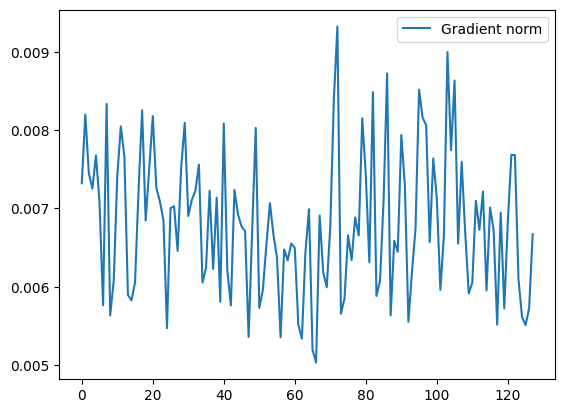

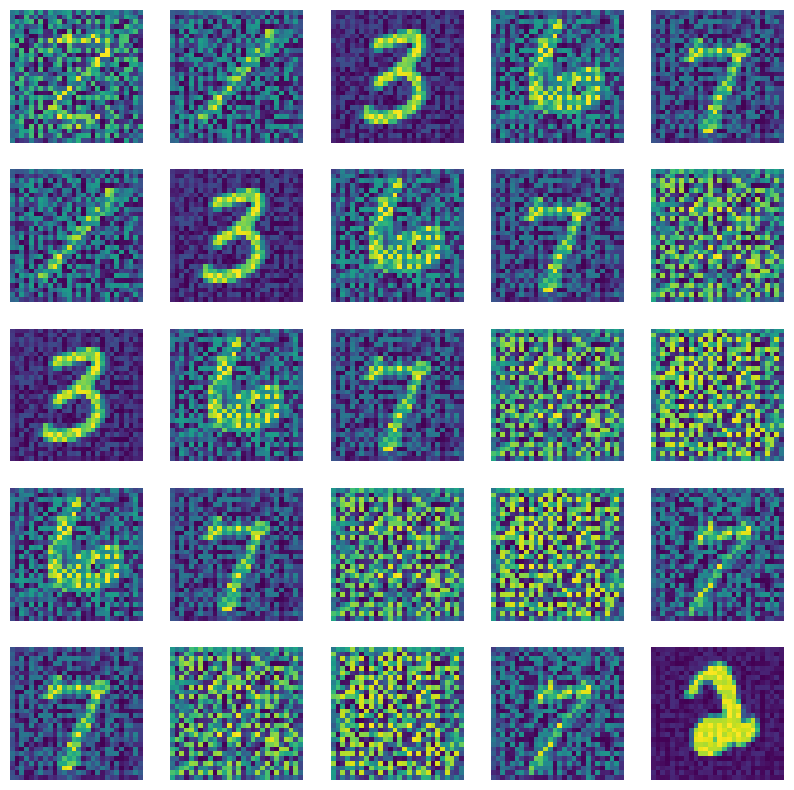

tensor(5.6894, device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
# Lets test it
batch_size = 128
real_data = next(iter(mnist_dl))[0]
real_data = real_data.to(device)
input_z = create_noise(batch_size, z_size, mode_z).to(device)
generated_data = gen_model(input_z)

gradient_penalty(real_data, generated_data, plot = True)


In [ ]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [ ]:
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 50
torch.manual_seed(1)
critic_iterations = 5

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z, batch_size).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.4650
Epoch 002 | D Loss >> -0.4887
Epoch 003 | D Loss >> -0.5441
Epoch 004 | D Loss >> -0.5931
Epoch 005 | D Loss >> -0.5919
Epoch 006 | D Loss >> -0.5693
Epoch 007 | D Loss >> -0.5574
Epoch 008 | D Loss >> -0.5460
Epoch 009 | D Loss >> -0.5275
Epoch 010 | D Loss >> -0.5211
Epoch 011 | D Loss >> -0.5167
Epoch 012 | D Loss >> -0.5184
Epoch 013 | D Loss >> -0.5092
Epoch 014 | D Loss >> -0.5111
Epoch 015 | D Loss >> -0.4983
Epoch 016 | D Loss >> -0.4986
Epoch 017 | D Loss >> -0.5001
Epoch 018 | D Loss >> -0.4957
Epoch 019 | D Loss >> -0.4979
Epoch 020 | D Loss >> -0.4960
Epoch 021 | D Loss >> -0.4945
Epoch 022 | D Loss >> -0.4889
Epoch 023 | D Loss >> -0.4855
Epoch 024 | D Loss >> -0.4947
Epoch 025 | D Loss >> -0.4885
Epoch 026 | D Loss >> -0.4920
Epoch 027 | D Loss >> -0.4915
Epoch 028 | D Loss >> -0.4846
Epoch 029 | D Loss >> -0.4864
Epoch 030 | D Loss >> -0.4894
Epoch 031 | D Loss >> -0.4898
Epoch 032 | D Loss >> -0.4877
Epoch 033 | D Loss >> -0.4887
Epoch 034 

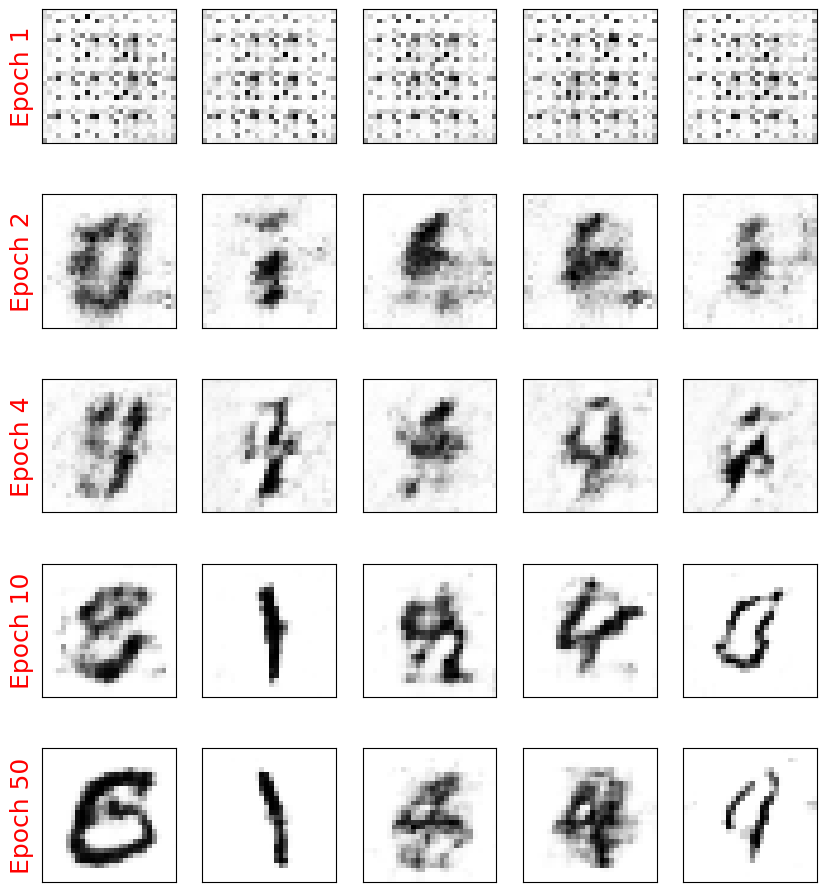

In [ ]:
selected_epochs = [1, 2, 4, 10, 50]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()


<br>
<br>

----